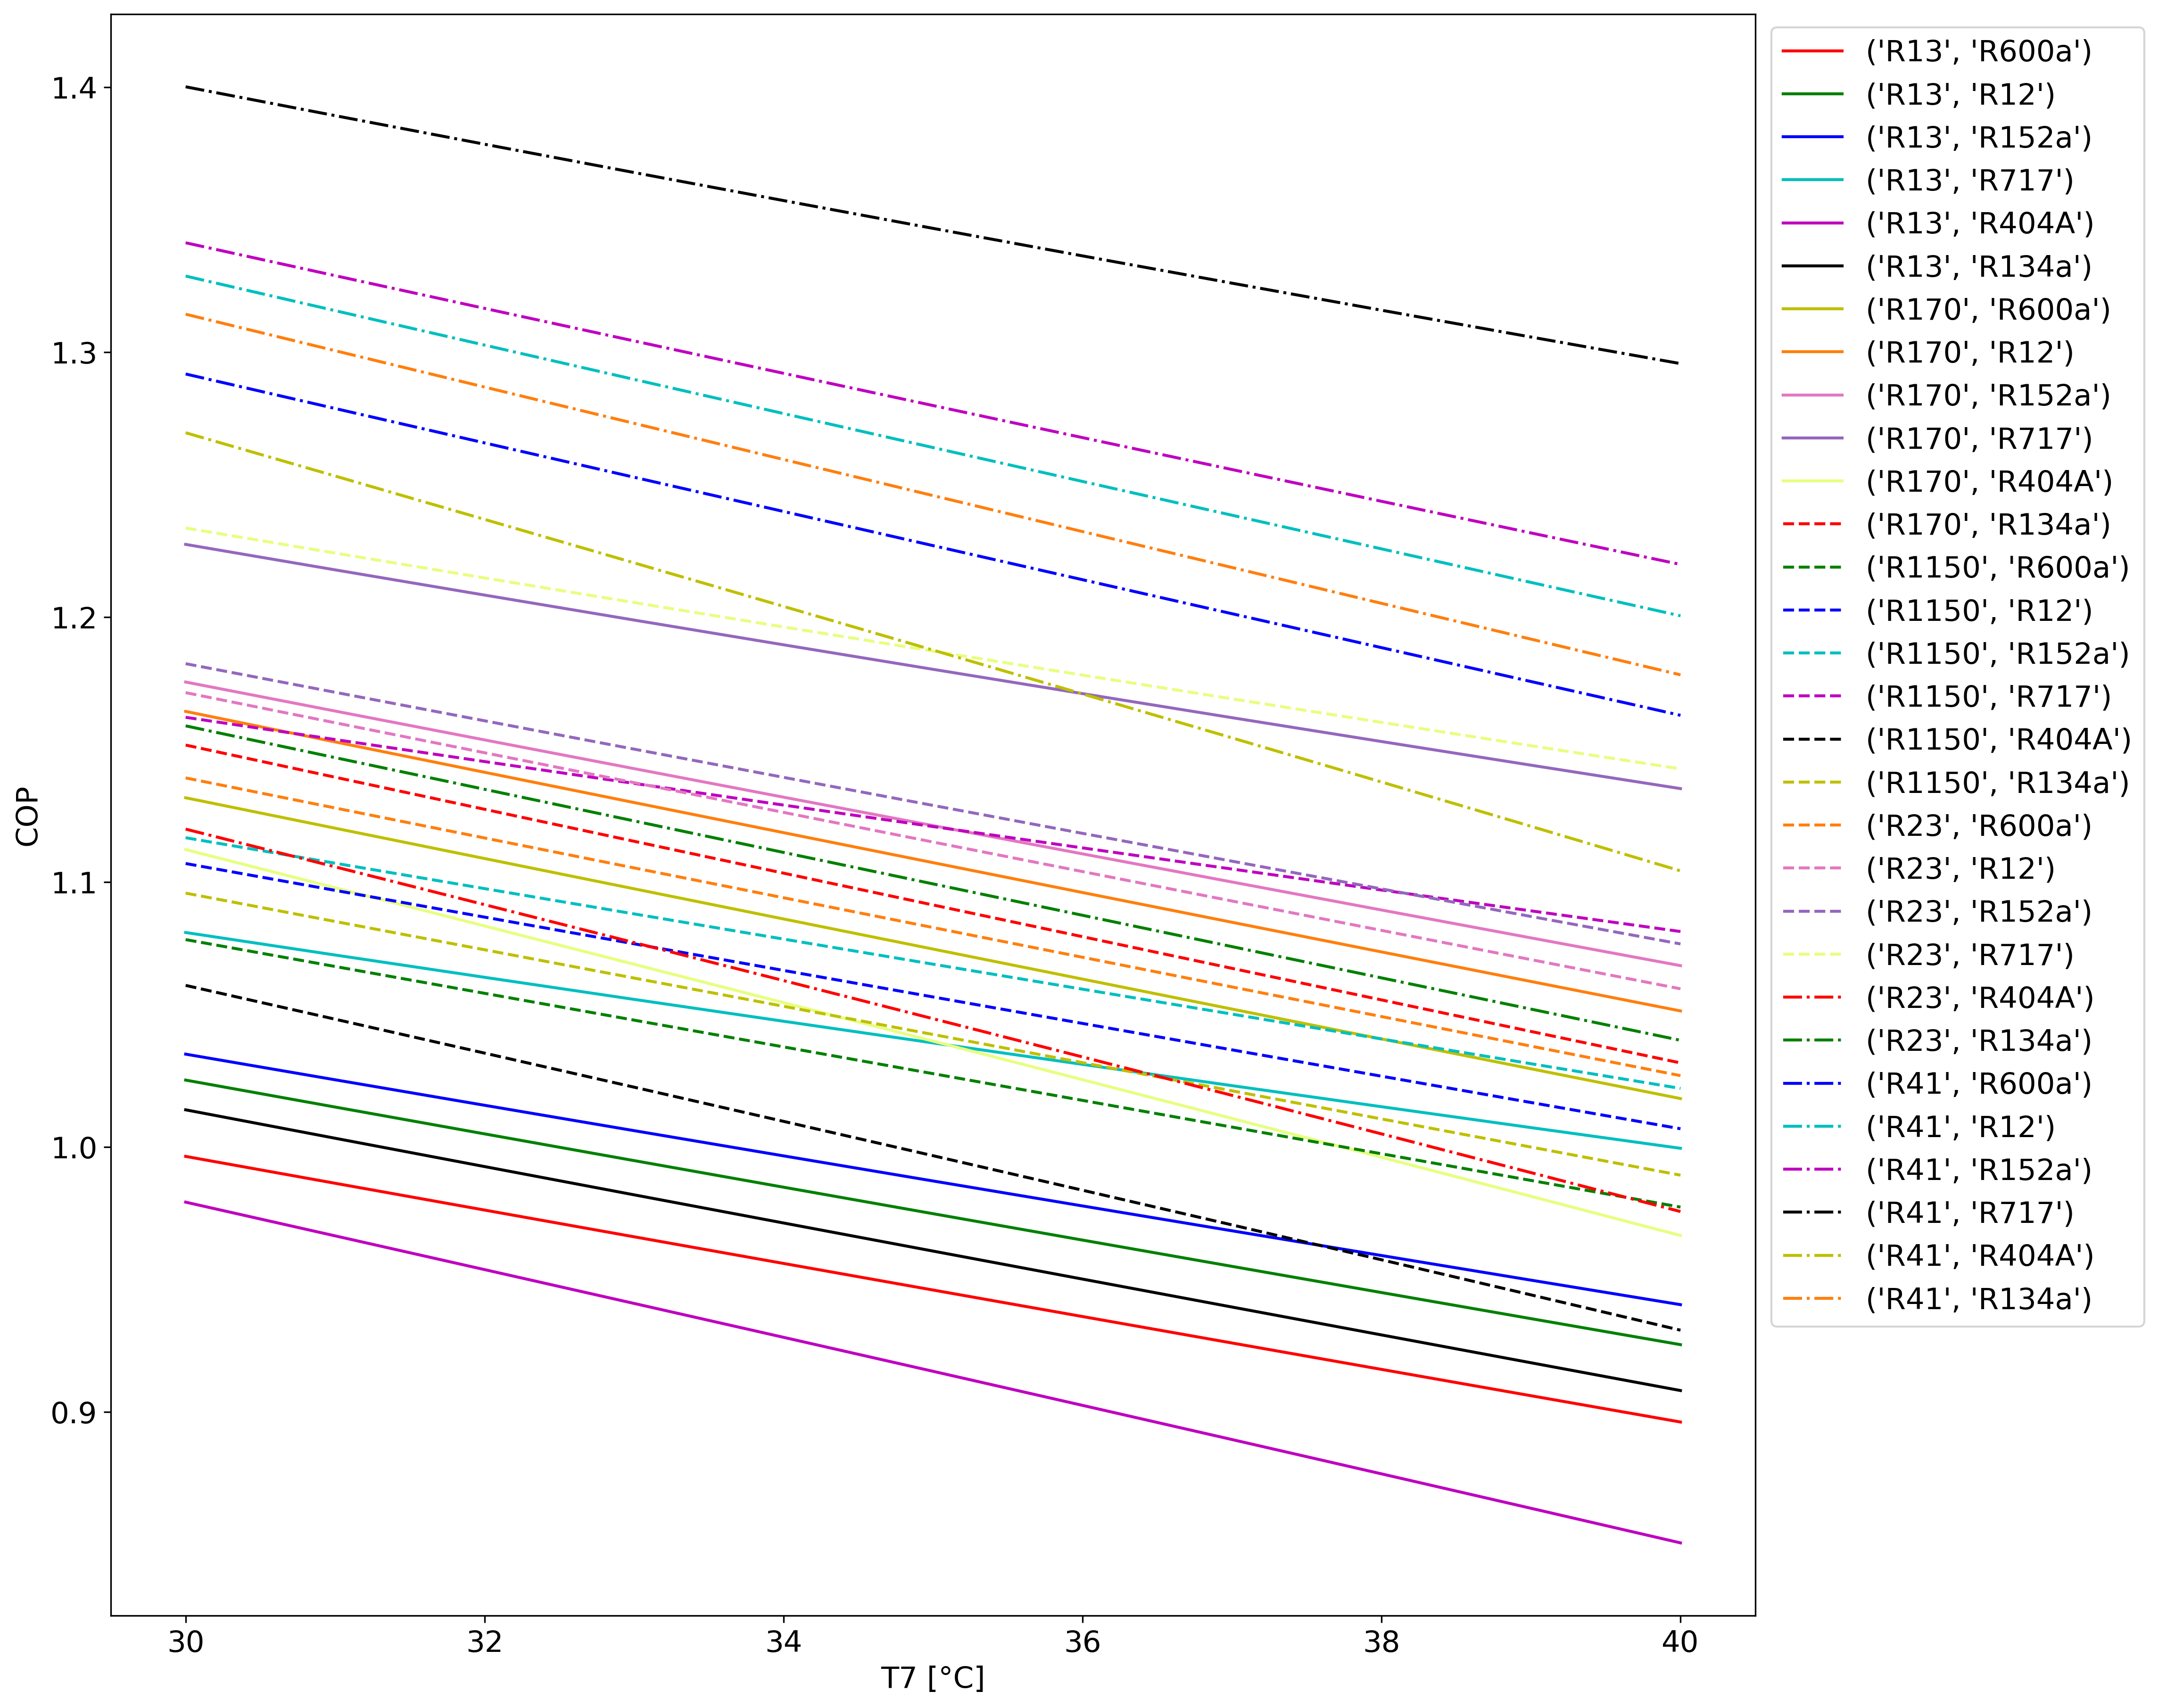

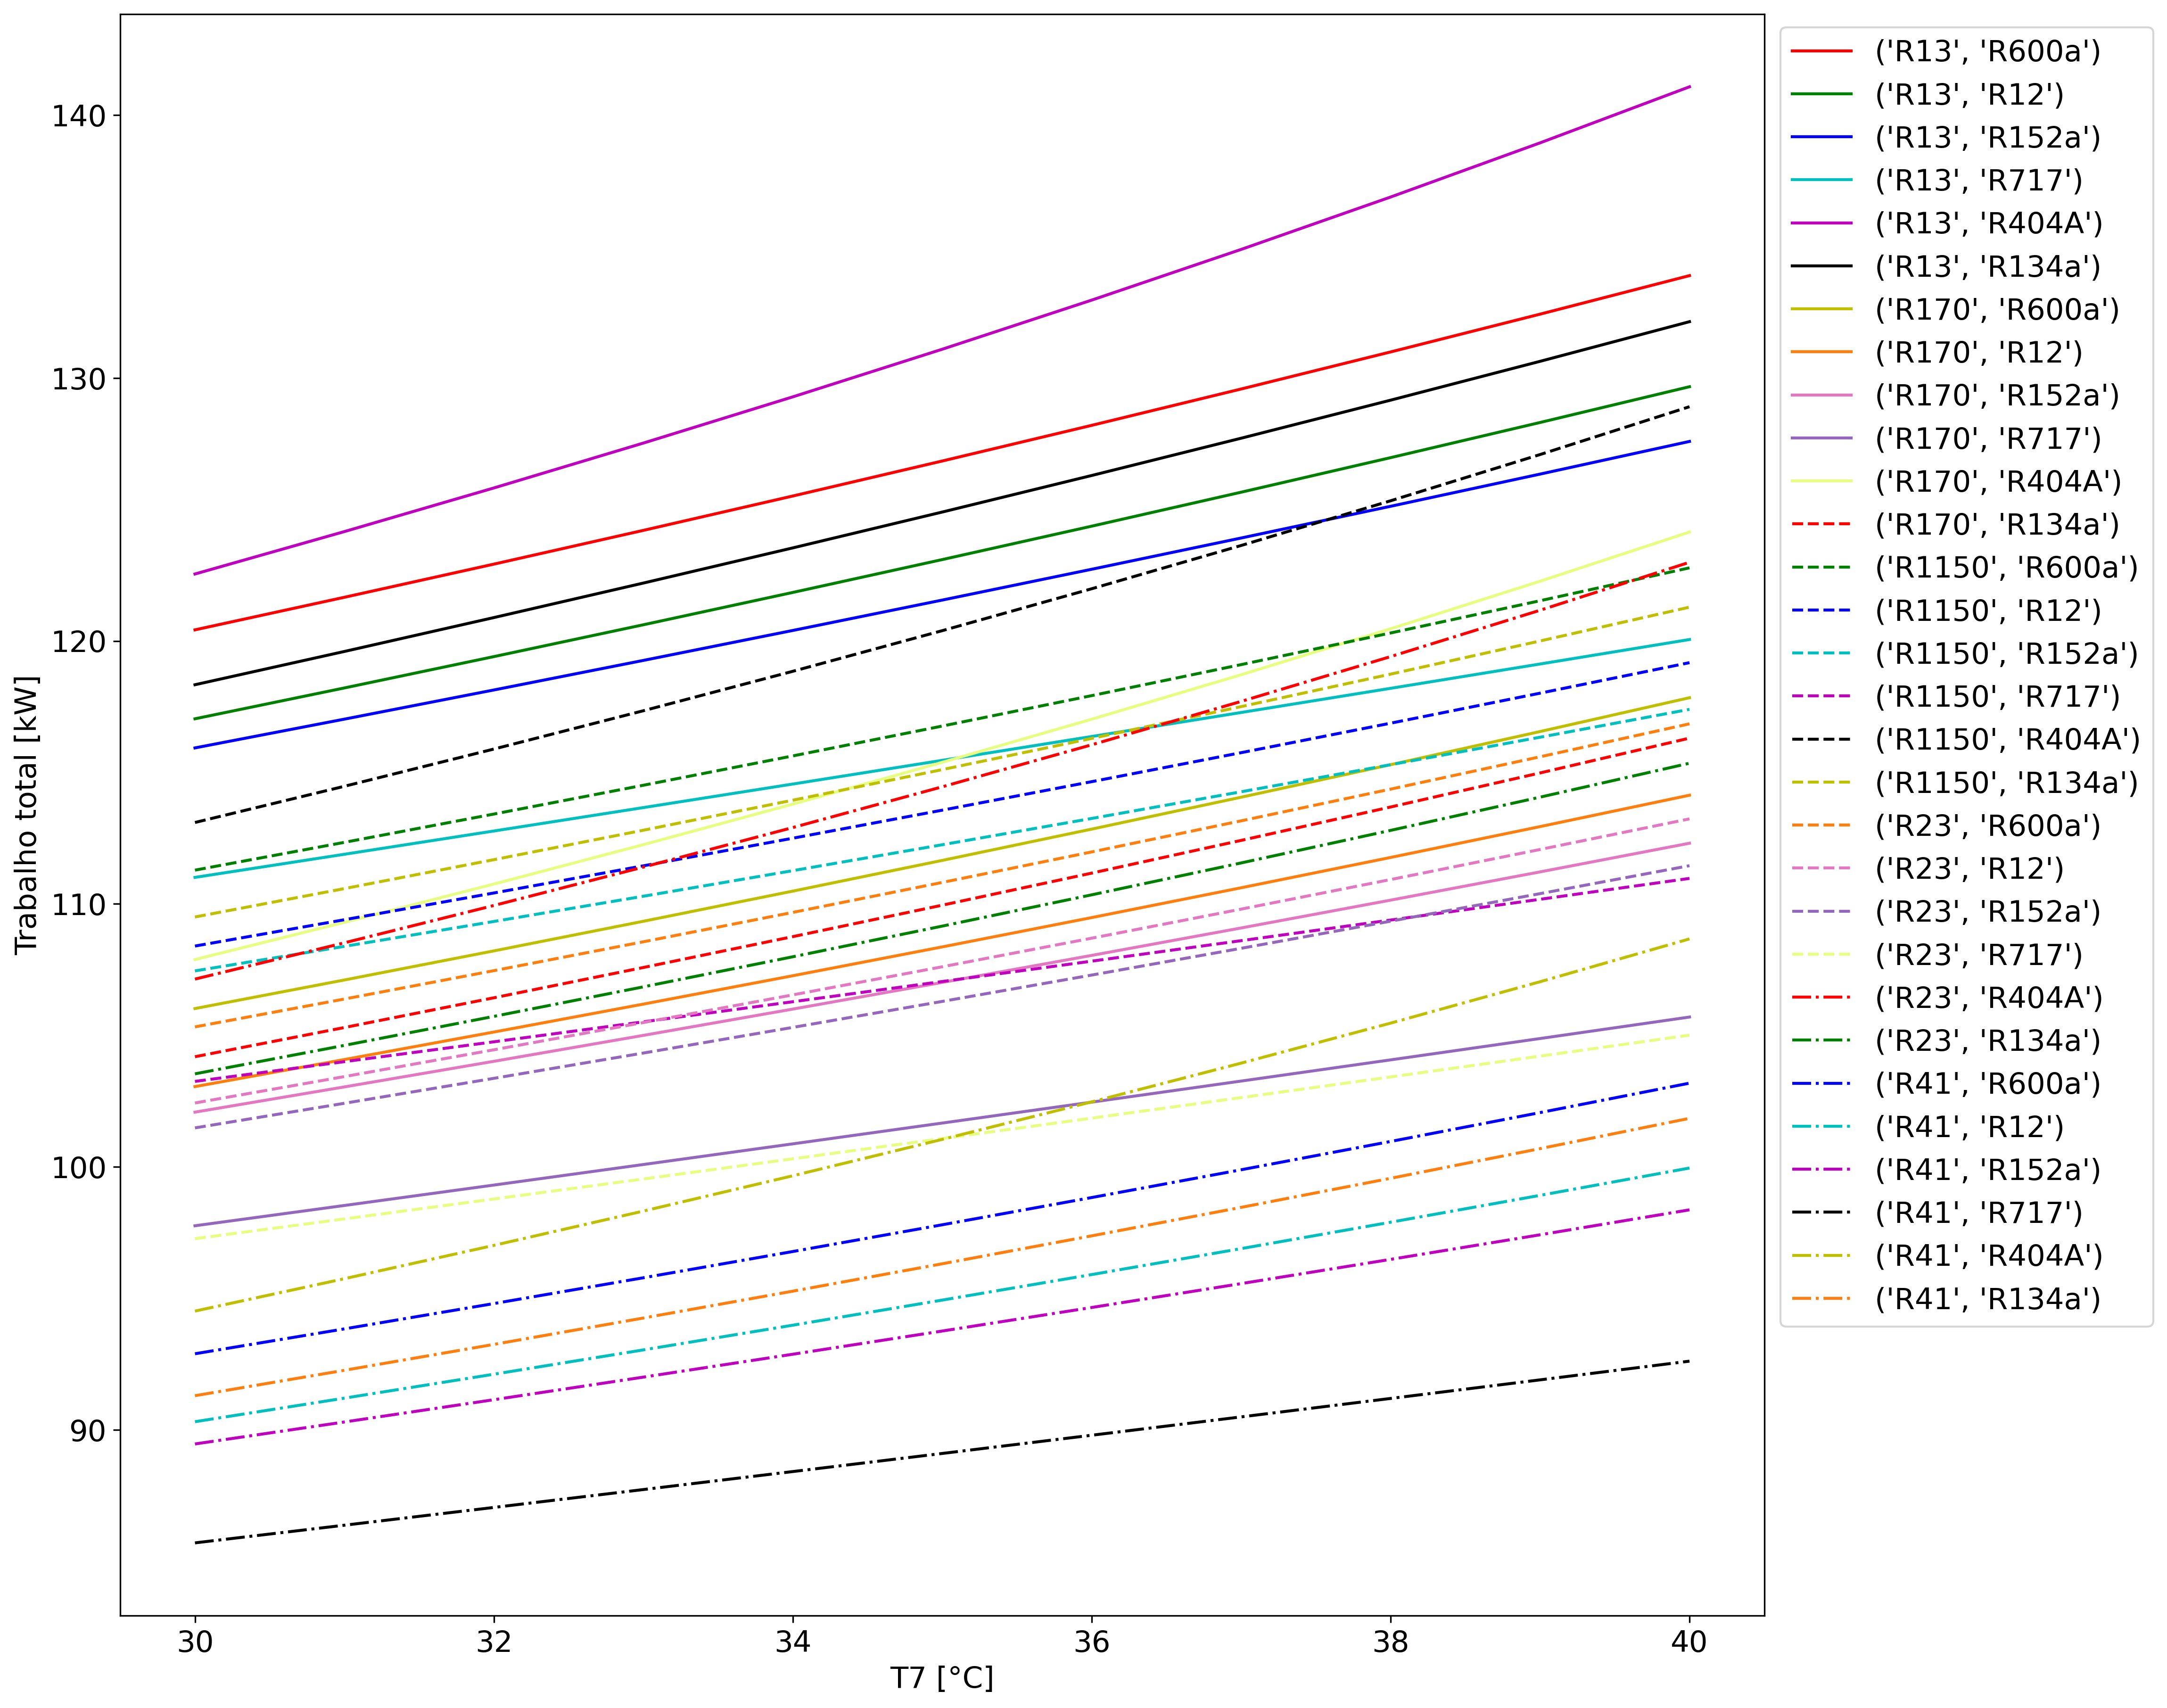

In [4]:
#Bibliotecas
from CoolProp.CoolProp import PropsSI as CP
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import get_test_data

#Listas
registro_fluidos = []
COP_lista = []
lista_T7 = []
Wcomp_total_lista = []
cont = []
lista_r1 = []
lista_r2 = []

#Lista de coeficientes politrópicos
for T7 in range (30, 41, 1):
    T7 += 273.15
    cont.append(T7)

#Lista de características para as curvas do gráfico
lista_cor = ['r','g','b', 'c', 'm', 'k', 'y', 'tab:orange', 'tab:pink', 'tab:purple', (0.9, 1, 0.5)]
lista_ls = ['-', '--', '-.', ':']
caracteristicas = []
for ls in lista_ls:
    for cor in lista_cor:
        caracteristicas.append((cor, ls))

#Dados do problema
Pfrig = 120 * 1000 #[W]
T1 = -80 + 273.15 #[K]
T3 = -8 + 273.15 #[K]
T5 = -12 + 273.15 #[K]
fluid_high_lista = ['R600a', 'R12', 'R152a', 'R717', 'R404A', 'R134a']
fluid_low_lista = ['R13', 'R170', 'R1150', 'R23', 'R41']
drop_suc = 12000 #[Pa]
drop_desc = 24000 #[Pa]
n = 1.1

#Loop nos dois ciclos - variação dos refrigerantes e do coeficiente politrópico 
for fluid_low in fluid_low_lista:
    #Ciclo inferior
    P1 = CP('P', 'T', T1, 'Q', 1, fluid_low) 
    h1 = CP('H', 'T', T1, 'Q', 1, fluid_low)
    ha = h1
    Pa = P1 - drop_suc
    Ta = CP('T', 'H', ha, 'P', Pa, fluid_low)
    Pb = Pa
    Tb = Ta + 4 #superaquecimento de 4°C na admissão
    vb = 1 / CP('D', 'T', Tb, 'P', Pb, fluid_low)
    P3 = CP('P', 'T', T3, 'Q', 0 , fluid_low)
    P2 = P3
    r1 = P2/P1
    lista_r1.append(r1)
    Pc = P2 + drop_desc
    h3 = CP('H', 'T', T3, 'Q', 0, fluid_low)
    h4 = h3
    m_flow_low = Pfrig / (h1 - h4)
    for fluid_high in fluid_high_lista:
        #Pressão crítica do fluido superior
        P_crit_high = CP('PCRIT', fluid_high)
        #Ciclo superior
        P5 = CP('P', 'T', T5, 'Q', 1, fluid_high)
        h5 = CP('H', 'T', T5, 'Q', 1, fluid_high)
        hw = h5
        Pw = P5 - drop_suc
        Tw = CP('T', 'H', hw, 'P', Pw, fluid_high)
        Px = Pw
        Tx = Tw + 4 #superaquecimento de 4°C na admissão
        vx = 1 / CP('D', 'T', Tx, 'P', Px, fluid_high)
        par_fluido = (fluid_low, fluid_high)
        registro_fluidos.append(par_fluido)
        for T7 in cont:
            P7 = CP('P', 'T', T7, 'Q', 0, fluid_high)
            P6 = P7
            r2 = P6/P5
            lista_r2.append(r2)
            Py = P6 + drop_desc
            h7 = CP('H', 'T', T7, 'Q', 0, fluid_high)
            h8 = h7
            #Ciclo inferior
            vc = (Pb * vb ** n / Pc)**(1 / n)
            hc = CP('H', 'P', Pc, 'D', 1 / vc, fluid_low)
            h2 = hc
            #Trabalho específico do compressor do ciclo inferior
            w_low = n / (n-1) * Pb * vb * ((Pc/Pb)**((n-1)/n) - 1)
            #Trabalho do compressor do ciclo inferior
            Wcomp_low = m_flow_low * w_low
            #Calor trocado no trocador central
            Qcond_low =  m_flow_low * (h2 - h3)
            #Ciclo superior
            Qevap_high = Qcond_low
            m_flow_high = Qevap_high / (h5 - h8)
            #Verificação da pressão crítica
            if P_crit_high > P6:
                lista_T7.append(T7-273.15)
                #Trabalho específico do compressor do ciclo superior
                w_high = n / (n-1) * Px * vx * ((Py/Px)**((n-1)/n) - 1)
                #Trabalho no compressor do ciclo superior
                Wcomp_high = m_flow_high * w_high
                #Trabalho total do ciclo
                Wcomp_total = Wcomp_low + Wcomp_high
                Wcomp_total_lista.append(Wcomp_total / 1000)
                #COP
                COP = Pfrig / Wcomp_total
                COP_lista.append(COP)
            else:
                print ('A pressão P6 = {:0.2f} kPa (n = {}, fluido inf = {}, fluido sup = {}) é maior do que a ' 
               'pressão crítica do {} e, por isso, o ponto não foi incluído no gráfico'.format(P6 / 1000,n,fluid_low,
                                                                                               fluid_high, fluid_high))

if len(cont) != 0:
    plt.rc('xtick', labelsize = 15)
    plt.rc('ytick', labelsize = 15)
    plt.figure(figsize = [15, 15], dpi = 300)
    for i in range (0, len(COP_lista), len(cont)):
        eixo_x = []
        eixo_y = []
        for j in range (i, i + len(cont), 1):
            eixo_x.append(lista_T7[j])
            eixo_y.append(COP_lista[j])
        plt.plot(eixo_x, eixo_y, color = caracteristicas[int(i/len(cont))][0], 
                 linestyle = caracteristicas [int(i/len(cont))][1], 
                 label=registro_fluidos[int(i/len(cont))])
        plt.xlabel('T7 [°C]', size = 15)
        plt.ylabel('COP', size = 15)
    plt.legend(prop={'size' : 15}, bbox_to_anchor =(1.001, 1.001))
    plt.show()
else:
    print('Todos os pontos são inválidos')

if len(cont) != 0:
    plt.rc('xtick', labelsize = 15)
    plt.rc('ytick', labelsize = 15)
    plt.figure(figsize = [15, 15], dpi = 300)
    for i in range (0, len(Wcomp_total_lista), len(cont)):
        eixo_x = []
        eixo_y = []
        for j in range (i, i + len(cont), 1):
            eixo_x.append(lista_T7[j])
            eixo_y.append(Wcomp_total_lista[j])
        plt.plot(eixo_x, eixo_y, color = caracteristicas[int(i/len(cont))][0], 
                 linestyle = caracteristicas [int(i/len(cont))][1], 
                 label=registro_fluidos[int(i/len(cont))])
        plt.xlabel('T7 [°C]', size = 15)
        plt.ylabel('Trabalho total [kW]', size = 15)
    plt.legend(prop={'size' : 15}, bbox_to_anchor =(1.001, 1.001))
    plt.show()
else:
    print('Todos os pontos são inválidos')
